# Webcrawler for Crypto Currency online Media References

## MA5832 Assessment 3
## Matthew Moore
## Jc626851
## 1379701




## Introducton

The ongoing prevalence and adoption of cryptocurrencies has created a unique trading environment with low barriers to entry.  This has created an environment where the experienced and inexperienced alike can adopt, use and trade in crypto currencies creating some unique challenges.  Having a mix of actors of different experience and education levels means two things; they will be influenced differently by online commentary, it's content and sentiment, and that they will also produce online commentary and feedback differently.  This diverse and complex interaction between a disparate community and market forces shaping the value of various crypto currencies makes it challenging to interpret what effect an announcement, event, or article will have on the market capitalisation of a specific crypto currency.

This Web scraper is designed as a proof of concept system, to obtain a broad corpus of easily accessed online articles pertaining to a subset of established crypto currencies in order to establish a dataset for investigating the relationship between subject matter, sentiment and market capitalisation.

## Websites to Be Consumed, and Why

In order to investigate the effect of online-media references to crypto currency market outcomes, established crypto currencies with a high degree of reference material needed to be identified.  It was also decided that the data set should cover a diverse range of material, formats, and topics, as well as be easily located.  This was done to avoid the biases that would come from targeting specific communities which may have specific levels of technical understanding, or community biases concerning certain events, features, or outcomes.

In order to satisfy the above requirements, the Wikipedia page "List of Cryptocurrencies" (https://en.wikipedia.org/wiki/List_of_cryptocurrencies) was taken as a good starting point.  Wikipedia is a well known website, and is accessible world wide by users of various technical backgrounds, so it was felt that this would give access to a fairly unbiased set of data.  

The "List of Cryptocurrencies" article also contains a limited set of established currencies listed, which has the advantage of reducing the initial scope of this study to 26 crypto currencies which have an extended history, and extensive reference material.

The overall list of websites to be consumed by the WebCrawler was obtained as follows:  For each of the crypto currencies referenced in the initial page, it's corresponding Wikipedia article was opened and added as the first corpus document for each respective currency.  The reference list for these articles was then scraped, to obtain a broader list of articles, sites, whitepapers and other reference material.  This extended list of websites was then scraped for article text.  Finally, to ensure that references not pertaining to the currency itself were not included in the dataset, the page contents was checked to ensure that the crypto currency or it's ticker symbol was included somewhere in the article text.


## Data Content Coverage

Due to the nature of the site selection methodology, a diverse selection of content has been covered.  Provided that a site was referenced in a crypto currency articles references table, and that the link was not a pdf, and that the destination page contained a reference to the crypto currency, the website content was included in the corpus.  This resulted in a range of documents being included with different target audiences and content types.  Some examples of sites covered include: Washingtonpost.com, motherboard.vice.com, ssrn.com, arxiv.org, cnbc.com, tether.to, and doi.org, and the material covers news media, community and development pages, blogs, and technical websites.  Overall this approach gave us 26 Wikipedia articles, and 1308 external articles, for a total document count of 1334.

Interestingly there was a disparity in the document coverage for each currency.  As there were variations in age and popularity some cryptocurrencies had a wider set of documents than others.  Figure 1 shows considerably more material for Bitcoin than all others, good coverage for Ethereum, Dogecoin, Tether, Monero, Titcoin, and decreasing reference counts for other currencies.  This is expected to produce some bias in the data set, which will need to be addressed in the NLP analysis task.


(Figure 1: Document Coverage by Currency)
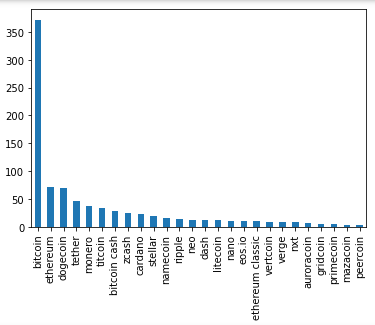

## Website Layout Complexity

Due to the open selection criteria for website selection, there's a wide variation in layout complexity.  The Wikipedia page used as a starting point, was highly structured, and tables and elements could easily be identified using div tags and class found using Google Developer tools as shown in Figure 2.  The structure used in Wikipedia allowed for simple identification of the table in "List of Crypto currencies" using beautifulsoup with the following syntax:

    soup.find('table',{'class':'wikitable sortable'})

Similarly, references were easily identified as ordered lists containing links of class "external text":

    references = soup.find_all('a', {"class" : "external text"})

Due to the varied nature of the sites contained in the Wikipedia reference lists it wasn't feasible to analyse each sites structure to determine how best to extract article text.  To get around this problem, beautiful soup was used to extract paragraph text from each site, and post processing was used to remove extraneous html or formatting:

    page_body = soup.find_all('p')

While this has the potential to leave relevant information unscraped, it was felt that this was a good "one size fits all" approach that allowed for successful data ingestion despite the variability in website complexity and layout.

(Figure 2: Google Developer Tools used to Inspect Wikipedia)
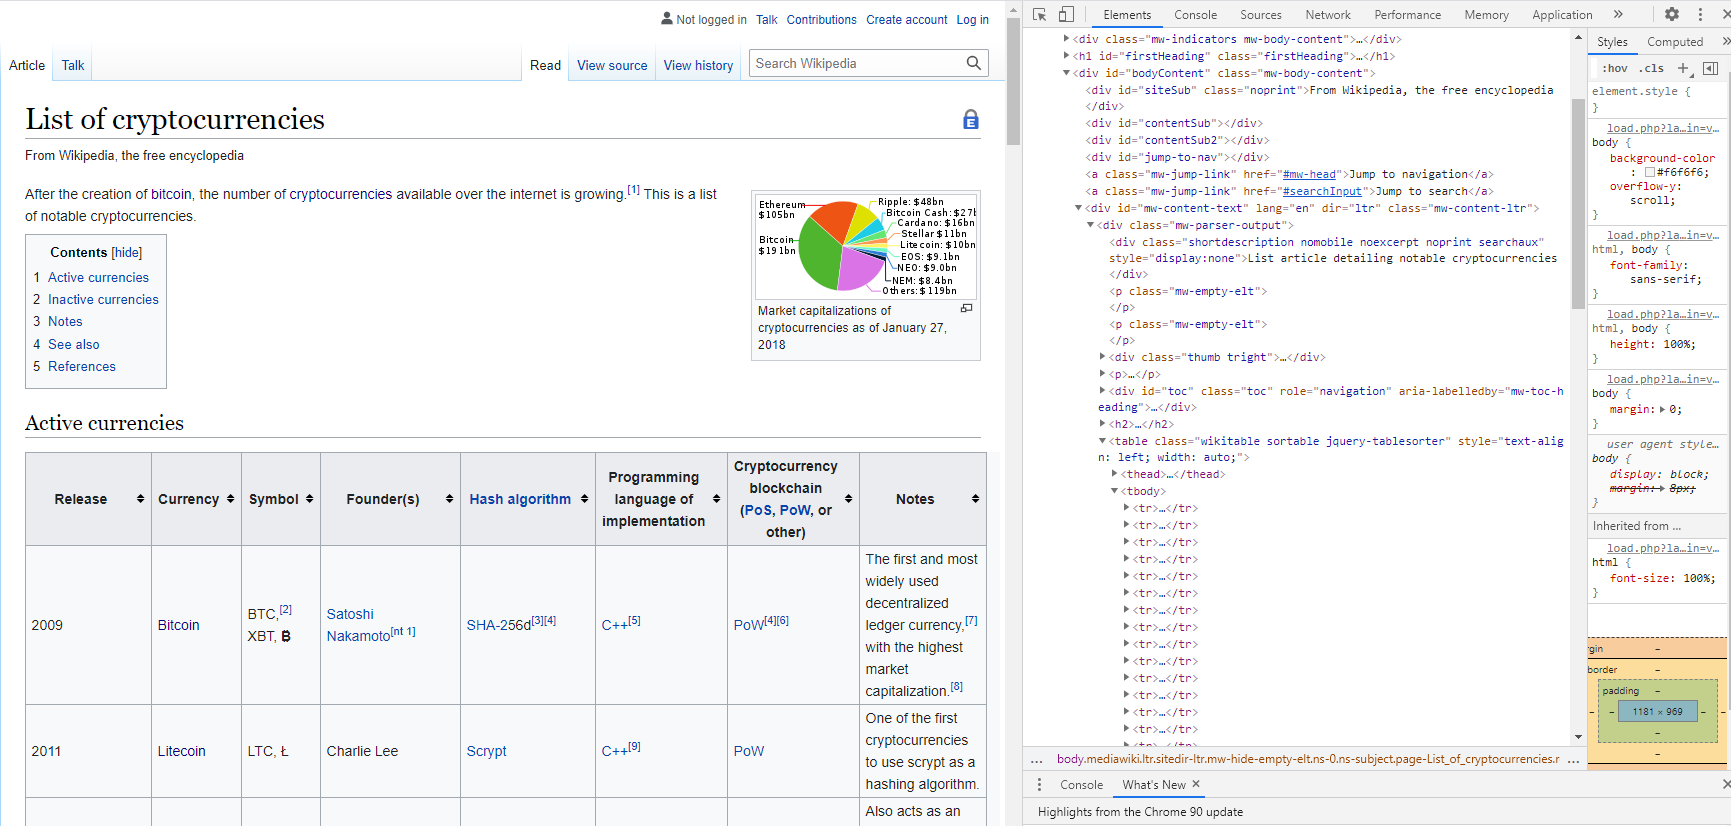

## Metadata Supplementation

The three main metadata requirements for this study are the Crypto Currency Name, The Ticker Symbol, and the current market capitalisation.  As the Currency name and ticker Symbol were contained in the initial Wikipedia page, these did not need supplementation.  

The Crypto Currency Market capitalisation was extracted at runtime using the coinmarketcap.com API (https://coinmarketcap.com/api/), using their supplied python code snippet to return a JSON object containing current market data for a range of currencies.

Coin name and market capitalisation was extracted from this object using regex via the followiing code:

    ##################################################
    ##  Get coin names and market cap from data

    # Split the json payload returned by coinmarketcap
    # on the id field to separate out the coins
    api_coins = str(data).split("{'id")

    # Create a new data frame to contain the current market capitalisation
    # for each crypto currency
    coin_market_caps = pd.DataFrame(columns=['symbol','marketcap'])

    # Returns the first capture group from an re regex sreach
    # and returns an empty string if None
    def none_to_string(text):
        if text is not None:
            return text.group(1)
        else:
            return ""

    # capture the symbol, and market cap for each coin object from the 
    # initial json payload
    for coin in api_coins:
        symbol = none_to_string(re.search("symbol':\s'(\w+)",coin))
        cap = none_to_string(re.search("market_cap':\s([\d\.]+)", coin))
        coin_market_caps.loc[len(coin_market_caps)] = [symbol.lower(),cap]

This yielded a dataframe containing the market capitalisation across a large segment of the market at the time of running, which was then saved as coin_market_caps.csv

## Content Extractor Methodology

Content extraction proceeded via 3 phases due the phased approach to website crawling.  The first phase was to extract an inital list of currencies from the "List of Crypto Currencies" Wikipedia page.

The initial page was loaded, and parsed using Beautifulsoup.  As the table class was known to be 'wikitable sortable' beautiful soup was used to load that table into a My_table:

    My_table = soup.find('table',{'class':'wikitable sortable'})

The column headers were extracted using regex to obtain a list of column names, which were cleaned of html tags and non word characters before being added to a list:

    headings = re.findall('(?ms)(?ms)<th>(.+?)<\/th>',str(rows[0]))
    
    for i in range(len(headings)):
        columns.append(clean_headers(headings[i]))
        
A dataFrame was created using the same column names as the wiki table, and each subsequent row was parsed using regex, and added to the dataFrame, before adding an additional column to store the uri of the Wikipedia article for each currency:

    raw_cryptos = pd.DataFrame(columns=columns)

    # Add each row of cryptocurrency table 
    # as a new row in Crypto Currrency Data Frame
    for i in range(1,len(rows)):
        rowdata = re.findall('(?ms)(?ms)<td>(.+?)<\/td>',str(rows[i]))
        raw_cryptos.loc[len(raw_cryptos)] = rowdata[:len(raw_cryptos.columns)]

    # Add column for Crypto Wiki page
    raw_cryptos.insert(len(raw_cryptos.columns), "wiki_page","", allow_duplicates=True)

Once ingested into the dataFrame, each value was cleaned to remove html references, formatting, and invalid characters, and the URI for each entries wikipedia article was extracted and inserted into the wiki_page column.

The next phase of extraction involved opening each page in the wiki_page column and if the page loaded successfully, all paragraph text was extracted cleaned and concatenated into a corpus dataframe:

    # Check that the page loaded corectly
    if page.status_code==200:
        # Fetch all paragraph text and load each paragraph into the corpus
        page_body = soup.find_all('p')
        
        # Get all paragraph text from page
        page_body = soup.find_all('p')

        #construct complete page text
        complete_page_text = ""
        for paragraph in page_body:
            complete_page_text += clean_body_text(paragraph.text).lower() + "\n"

        corpus.loc[len(corpus)] = [cryptos.Currency[i], cryptos.Symbol[i], cryptos.wiki_page[i] , complete_page_text]

Folowing body text ingestion, the site references were identified using beautifulSoup to search for links with the class "external text".  Each link was checked to ensure that it wasn't linking to nother Wikipedia page, and that it wasn't a pdf document before it was added to the link_list Dataframe

        # Fetch References
        # References are in an ordered list
        # containing class "External Text"
        references = soup.find_all('a', {"class" : "external text"})
        for ref in references:
            if ("wikipedia" not in ref.get('href')) and (".pdf" not in ref.get('href')):
                #print(ref.get('href'))
                #print(" ")
                link_list.loc[len(link_list)] = [cryptos.Currency[i], cryptos.Symbol[i], ref.get('href')]

Finally, each url in link_list was opened, and the paragraph text was cleansed and added to the corpus.  This approach simplified the process of ingesting data from a highly varied series of website, by focusing on elements that are most likley to contain relevant information:

    
    # Open each url in link_list
    # And ingest body content
    for i in range(len(link_list)):
        try:
            page = requests.get(link_list.document_url[i])
        except Exception as e:
            print("Page load error." + str(e))
        soup = BeautifulSoup(page.text, 'html.parser')
        #print("Page(" + str(i) +")" + str(link_list.document_url[i]))

        # save corpus every 50 pages
        if i%50==0:
            expanded_corpus.to_csv ('expanded_corpus.csv', index = None, header=True)
            print("Page(" + str(i) +")" + str(link_list.document_url[i]))
            
        #Check that page has loaded successfully
        if page.status_code==200:

            # Get all paragraph text from page
            page_body = soup.find_all('p')

            #construct complete page text
            complete_page_text = ""
            for paragraph in page_body:
                complete_page_text += clean_body_text(paragraph.text).lower() + "\n"

            # if page text contains the currency name or ticker, add it to the corpus
            if (link_list.coin[i] in complete_page_text) or (link_list.ticker[i] in complete_page_text):
                expanded_corpus.loc[len(expanded_corpus)] = [link_list.coin[i], link_list.ticker[i], link_list.document_url[i], complete_page_text]


The complete expanded_corpus dataframe is saved to file as a CSV for analysis using NLP and Machine Learning.


## Webcrawler usage and Application

As the webcrawler was built using python, it was constructed inline with the scraping, and cleansing components.  The architecture fiagram can be seen in Figure 3 below:

(Figure 3: Web Crawler Architecture)
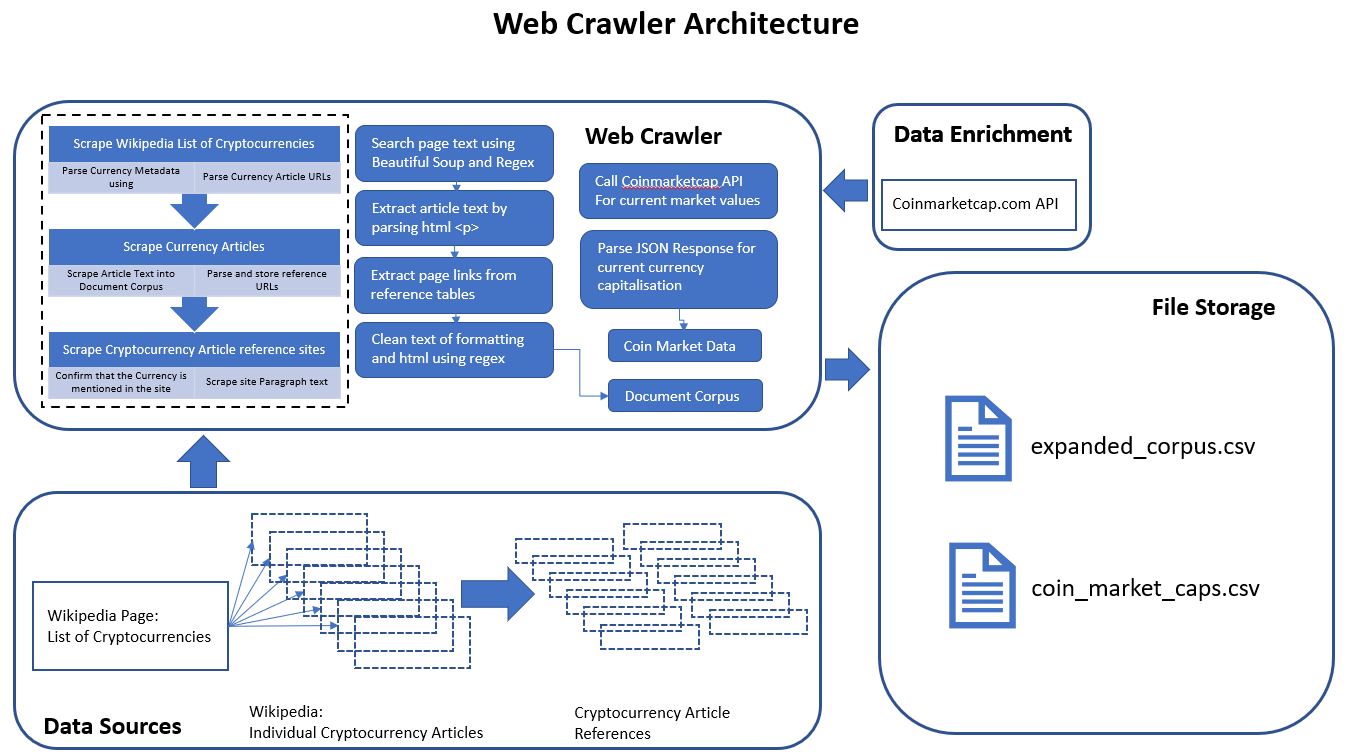

This approach allowed for beautifulSoup to be used for both web scraping and crawling, by starting with the initial page, and progresively ingestng content and links for the subsequent set of articles to be ingested.

As this was not a selinium based aproach, screenshots of the process are not available, however the Webcrawler was configured to output any errors (Some pages were no longer in production) and an indication of progress every 100 pages.  This output is shown below in Figure 4:

(Figure 4: Webcrawler Progress)
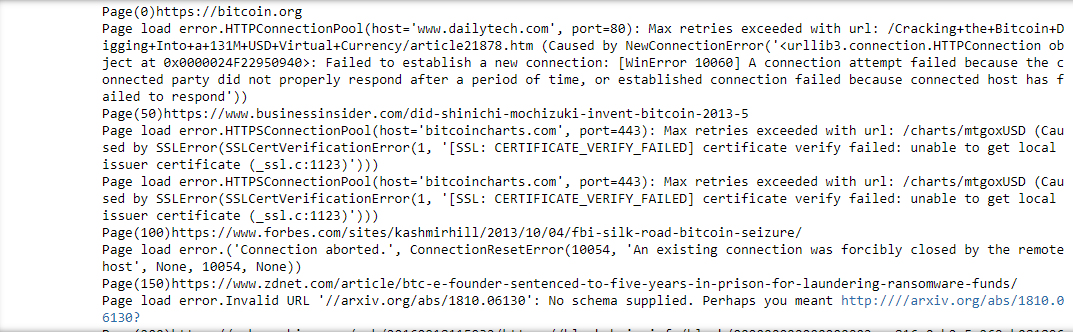

## Data Processing, Cleaning, and Storage

The ingested data contained spurrious information such as HTML tags, citations, invallid characters, and spurrious line breaks.  Processing and cleaning was performed at various points along the pipeline using the following functions:

Clean_headers was used to remove extraneous html, and invalid characters from the crypto currency table headers, so that they could be used as column names in a pandas dataframe

    # Remove html tags from strings
    def clean_headers(text):
        output = re.sub("<.+?>", "", text)
        output = re.sub(" ","_",output)
        output = re.sub("[^a-zA-Z_]", "", output)
        if output is not None:
            return output
        else:
            return text
            
Remove_new_line, uses regex to remove new line characters from body text:

    def remove_new_line(text):
        output = re.sub("\n", "", text)
        if output is not None:
            return output
        else:
            return text


Extract_url uses regex to create a capturegroup for html link references:

    def extract_url(text):
        output = re.search('href="([^"]+)',text)
        if output is not None:
            return output.group(1)
        else:
            return text

Clean_html removes any html tags, new line characters, citations found in wikipedia, and url encoded ampersands:

    # Remove html tags from strings
    def clean_html(text):
        # Remove tags
        text = re.sub("<.+?>", "", text)
        # remove \n
        text = re.sub("\\n", "", text)
        # remove citations
        text = re.sub("\[.+?\]", "", text)
        # replace &amp; with &
        text = re.sub("&amp;", "&", text)
        return text

Clean_body_text removes quote marks, square bracket enclosed text and characters apart from word characters, periods, parenthesies, comas, digets and spaces:

    # Remove citation [302] and quotes "quote"
    # and non ASCII text
    def clean_body_text(text):
        output = re.sub("\[\w*\]", "", text)
        output = re.sub('"', "", output)
        output = re.sub('[^a-zA-Z\.,\'\(\)\d\s]', "", output)
        if output is not None:
            return output
        else:
            return text
            
Each of these methods as well as conversion of text to lower case are applied during the scraping process to remove some complexity and variability from the dataset.

## Summary and Visualisation of Harvested data


After crawling Wikipedia and external sites for page data, a total of 1334 documents were processed and ingested.  Due to the variability in popularity of the different cryptocurrencies, Figure 1 shows a heavy skew towards the common currencies, Bitcoin, Ethereum and Dogecoin, which is to be expected due to the page selection process.

Exploratory data analysis was performed against the scraped and cleansed data, and a sample document is shown in Figure 5, the top word occurrences are shown in Figure 6, and least common words in figure 7.

The sample document is in lower case, and is largely clean, but there remains some formatting to be removed by the recipient which is not ideal, however this can be cleaned up during the NLP process.  Looking at the most common word counts, they're mostly common English words that would be expected, however bitcoin does stand out as being over represented which is unsurprising due to the bias towards bitcoin articles.

The display of rare words is concerning as they consist of high entropy strings which are unlikely to convey meaning. Due to their low representation, it was decided to leave these in as it wasn't expected that they wouldn't cause a material skew to the results.


(Figure 5: Sample extracted Document)
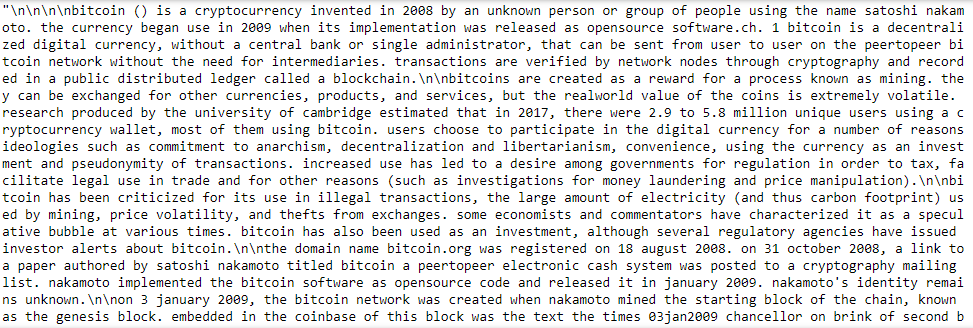

(Figure 6: Top Words in Corpus)
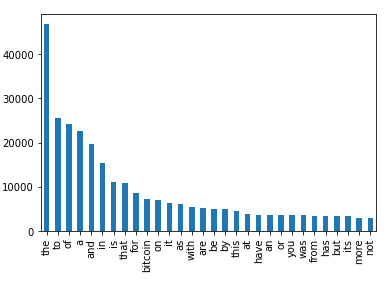

(Figure 7: Least Common Words in Corpus)
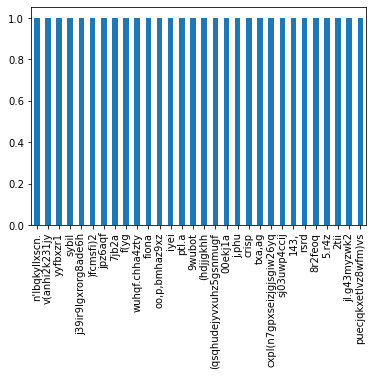

In [23]:
#Import Libraries
import requests
from bs4 import BeautifulSoup


In [3]:
#Specify with which web page you are going to be scraping
page = requests.get('https://en.wikipedia.org/wiki/List_of_cryptocurrencies')
#Parse the HTML into the BeautifulSoup parse tree format
soup = BeautifulSoup(page.text, 'html.parser')


In [4]:
# confirm page load and title
title = soup.find('title')
print(title.string)

List of cryptocurrencies - Wikipedia


In [5]:
# Extract table containi CryptoCurrency list, and article URLs
My_table = soup.find('table',{'class':'wikitable sortable'})
#print(My_table)

In [6]:
# Get list of coins in wiki
# scrape individual coin pages for corpus
# scrape references for extended corpus
# process for distinguishing features
# Determine if distinguishing features alongside date of releace can accurately predict market cap

import re
import numpy as np
import pandas as pd

raw_cryptos = []
#get all the data stored  into <tr>
rows =  My_table.findAll('tr')

# Remove html tags from strings
def clean_headers(text):
    output = re.sub("<.+?>", "", text)
    output = re.sub(" ","_",output)
    output = re.sub("[^a-zA-Z_]", "", output)
    if output is not None:
        return output
    else:
        return text

columns=[]
headings = re.findall('(?ms)(?ms)<th>(.+?)<\/th>',str(rows[0]))

for i in range(len(headings)):
    columns.append(clean_headers(headings[i]))
    
raw_cryptos = pd.DataFrame(columns=columns)

# Add each row of cryptocurrency table 
# as a new row in Crypto Currrency Data Frame
for i in range(1,len(rows)):
    rowdata = re.findall('(?ms)(?ms)<td>(.+?)<\/td>',str(rows[i]))
    raw_cryptos.loc[len(raw_cryptos)] = rowdata[:len(raw_cryptos.columns)]

# Add column for Crypto Wiki page
raw_cryptos.insert(len(raw_cryptos.columns), "wiki_page","", allow_duplicates=True)


raw_cryptos.head(5)

,Release,Currency,Symbol,Founders,Hash_algorithm,Programming_language_of_implementation,Cryptocurrency_blockchain_PoS_PoW_or_other,Notes,wiki_page
0,2009\n,"<a href=""/wiki/Bitcoin"" title=""Bitcoin"">Bitcoi...","BTC,<sup class=""reference"" id=""cite_ref-Dixon_...","<a href=""/wiki/Satoshi_Nakamoto"" title=""Satosh...","<a href=""/wiki/SHA-2"" title=""SHA-2"">SHA-2</a>5...","<a href=""/wiki/C%2B%2B"" title=""C++"">C++</a><su...","<a class=""mw-redirect"" href=""/wiki/Proof-of-wo...",The first and most widely used decentralized l...,
1,2011\n,"<a href=""/wiki/Litecoin"" title=""Litecoin"">Lite...","LTC, Ł\n",Charlie Lee\n,"<a href=""/wiki/Scrypt"" title=""Scrypt"">Scrypt</...","<a href=""/wiki/C%2B%2B"" title=""C++"">C++</a><su...","<a class=""mw-redirect"" href=""/wiki/Proof-of-wo...",One of the first cryptocurrencies to use scryp...,
2,2011\n,"<a href=""/wiki/Namecoin"" title=""Namecoin"">Name...",NMC\n,"Vincent Durham<sup class=""reference"" id=""cite_...","<a href=""/wiki/SHA-2"" title=""SHA-2"">SHA-2</a>5...","<a href=""/wiki/C%2B%2B"" title=""C++"">C++</a><su...","<a class=""mw-redirect"" href=""/wiki/Proof-of-wo...","Also acts as an alternative, decentralized <a ...",
3,2012\n,"<a href=""/wiki/Peercoin"" title=""Peercoin"">Peer...",PPC\n,"Sunny King<br/>(pseudonym)<sup class=""noprint ...","<a href=""/wiki/SHA-2"" title=""SHA-2"">SHA-2</a>5...","<a href=""/wiki/C%2B%2B"" title=""C++"">C++</a><su...","<a class=""mw-redirect"" href=""/wiki/Proof-of-wo...",The first cryptocurrency to use POW and POS fu...,
4,2013\n,"<a href=""/wiki/Dogecoin"" title=""Dogecoin"">Doge...","DOGE, XDG, Ð\n",Jackson Palmer<br/>&amp; Billy Markus<sup clas...,"<a href=""/wiki/Scrypt"" title=""Scrypt"">Scrypt</...","<a href=""/wiki/C%2B%2B"" title=""C++"">C++</a><su...","<a class=""mw-redirect"" href=""/wiki/Proof-of-wo...","Based on the <a href=""/wiki/Doge_(meme)"" title...",


In [7]:
#  Tidy up some of the initial values
cryptos = raw_cryptos

def remove_new_line(text):
    output = re.sub("\n", "", text)
    if output is not None:
        return output
    else:
        return text

def extract_url(text):
    output = re.search('href="([^"]+)',text)
    if output is not None:
        return output.group(1)
    else:
        return text

# Remove html tags from strings
def clean_html(text):
    # Remove tags
    text = re.sub("<.+?>", "", text)
    # remove \n
    text = re.sub("\\n", "", text)
    # remove citations
    text = re.sub("\[.+?\]", "", text)
    # replace &amp; with &
    text = re.sub("&amp;", "&", text)
    return text

for i in range(len(cryptos)):
    cryptos.Release[i] = remove_new_line(cryptos.Release[i]).lower()
    cryptos.Release[i] = clean_html(cryptos.Release[i])
    cryptos.wiki_page[i] = "https://en.wikipedia.org/" + extract_url(cryptos.Currency[i]) 
    cryptos.Currency[i] = clean_html(cryptos.Currency[i]).lower()
    cryptos.Symbol[i] = re.search('(\w+)',cryptos.Symbol[i]).group(1).lower()
    cryptos.Founders[i] = clean_html(cryptos.Founders[i]).lower()
    cryptos.Hash_algorithm[i] = clean_html(cryptos.Hash_algorithm[i]).lower()
    cryptos.Programming_language_of_implementation[i] = clean_html(cryptos.Programming_language_of_implementation[i]).lower()
    cryptos.Cryptocurrency_blockchain_PoS_PoW_or_other[i] = clean_html(cryptos.Cryptocurrency_blockchain_PoS_PoW_or_other[i]).lower()
    cryptos.Notes[i] = clean_html(cryptos.Notes[i]).lower()
    
cryptos.head(5)

,Release,Currency,Symbol,Founders,Hash_algorithm,Programming_language_of_implementation,Cryptocurrency_blockchain_PoS_PoW_or_other,Notes,wiki_page
0,2009,bitcoin,btc,satoshi nakamoto,sha-256d,c++,pow,the first and most widely used decentralized l...,https://en.wikipedia.org//wiki/Bitcoin
1,2011,litecoin,ltc,charlie lee,scrypt,c++,pow,one of the first cryptocurrencies to use scryp...,https://en.wikipedia.org//wiki/Litecoin
2,2011,namecoin,nmc,vincent durham,sha-256d,c++,pow,"also acts as an alternative, decentralized dns.",https://en.wikipedia.org//wiki/Namecoin
3,2012,peercoin,ppc,sunny king(pseudonym),sha-256d,c++,pow & pos,the first cryptocurrency to use pow and pos fu...,https://en.wikipedia.org//wiki/Peercoin
4,2013,dogecoin,doge,jackson palmer& billy markus,scrypt,c++,pow,based on the doge internet meme.,https://en.wikipedia.org//wiki/Dogecoin


In [35]:
# Build corpus, and link list for each coin
corpus = pd.DataFrame(columns=['coin', 'ticker','document_url','document'])
link_list = pd.DataFrame(columns=['coin', 'ticker', 'document_url'])

#Specify with which web page you are going to be scraping
page = requests.get('https://en.wikipedia.org/wiki/List_of_cryptocurrencies')
#Parse the HTML into the BeautifulSoup parse tree format
soup = BeautifulSoup(page.text, 'html.parser')

# Remove citation [302] and quotes "quote"
# and non ASCII text
def clean_body_text(text):
    output = re.sub("\[\w*\]", "", text)
    output = re.sub('"', "", output)
    output = re.sub('[^a-zA-Z\.,\'\(\)\d\s]', "", output)
    if output is not None:
        return output
    else:
        return text

# Iterate through list of crypto currencies
# Ingest article into corpus for analysis, 
# and scrape reference URLs into link list

for i in range(len(cryptos)):
    page = requests.get(cryptos.wiki_page[i])
    soup = BeautifulSoup(page.text, 'html.parser')
    #print("***************************************")
    #print(str(cryptos.wiki_page[i]) + " Status(" + str(page.status_code) + ")")

    
    # Check that the page loaded corectly
    if page.status_code==200:
        # Fetch all paragraph text and load each paragraph into the corpus
        page_body = soup.find_all('p')

        #construct complete page text
        complete_page_text = ""
        for paragraph in page_body:
            complete_page_text += clean_body_text(paragraph.text).lower() + "\n"

        corpus.loc[len(corpus)] = [cryptos.Currency[i], cryptos.Symbol[i], cryptos.wiki_page[i] , complete_page_text]
                
        
        # Fetch References
        # References are in an ordered list
        # containing class "External Text"
        references = soup.find_all('a', {"class" : "external text"})
        for ref in references:
            if ("wikipedia" not in ref.get('href')) and (".pdf" not in ref.get('href')):
                #print(ref.get('href'))
                #print(" ")
                link_list.loc[len(link_list)] = [cryptos.Currency[i], cryptos.Symbol[i], ref.get('href')]

print("Current Corpus size: " + str(len(corpus)))
print("Reference list size: " + str(len(link_list)))

Current Corpus size: 26
Reference list size: 1308


In [9]:
##############################
## Iterate through Wiki references for crypto currencies for
## An expanded corpus
## Pages that don't contain either a reference to the crypto currency name
## or ticker are discarded...

expanded_corpus = corpus.copy(deep=True)
    
# Open each url in link_list
# And ingest body content
for i in range(len(link_list)):
    try:
        page = requests.get(link_list.document_url[i])
    except Exception as e:
        print("Page load error." + str(e))
    soup = BeautifulSoup(page.text, 'html.parser')
    #print("Page(" + str(i) +")" + str(link_list.document_url[i]))
    
    # save corpus every 50 pages
    if i%50==0:
        expanded_corpus.to_csv ('expanded_corpus.csv', index = None, header=True)
        print("Page(" + str(i) +")" + str(link_list.document_url[i]))
        
    # check that page has loaded correctly    
    if page.status_code==200:

        # Get all paragraph text from page
        page_body = soup.find_all('p')

        #construct complete page text
        complete_page_text = ""
        for paragraph in page_body:
            complete_page_text += clean_body_text(paragraph.text).lower() + "\n"

        # if page text contains the currency name or ticker, add it to the corpus
        if (link_list.coin[i] in complete_page_text) or (link_list.ticker[i] in complete_page_text):
            expanded_corpus.loc[len(expanded_corpus)] = [link_list.coin[i], link_list.ticker[i], link_list.document_url[i], complete_page_text]

expanded_corpus

# save corpus once complete
expanded_corpus.to_csv ('expanded_corpus.csv', index = None, header=True)

Page(0)https://bitcoin.org
Page load error.HTTPConnectionPool(host='www.dailytech.com', port=80): Max retries exceeded with url: /Cracking+the+Bitcoin+Digging+Into+a+131M+USD+Virtual+Currency/article21878.htm (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000024F22950940>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))
Page(50)https://www.businessinsider.com/did-shinichi-mochizuki-invent-bitcoin-2013-5
Page load error.HTTPSConnectionPool(host='bitcoincharts.com', port=443): Max retries exceeded with url: /charts/mtgoxUSD (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1123)')))
Page load error.HTTPSConnectionPool(host='bitcoincharts.com', port=443): Max retr

Page load error.No connection adapters were found for '//www.google.com/search?&q=%22Titcoin%22+site:news.google.com/newspapers&source=newspapers'
Page load error.Invalid URL '//scholar.google.com/scholar?q=%22Titcoin%22': No schema supplied. Perhaps you meant http:////scholar.google.com/scholar?q=%22Titcoin%22?
Page load error.HTTPConnectionPool(host='www.designntrend.com', port=80): Max retries exceeded with url: /articles/15814/20140623/porn-gets-currency.htm (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000024F2225B3D0>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))
Page load error.HTTPConnectionPool(host='majormindjob.com', port=80): Max retries exceeded with url: /wolf/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000024F2

In [10]:
#################################################
## Call coinmarketcap api, to get current data for a wide range of cryptos
## This code was taken from coinmarketcap.com
## In their developer tools documentation

from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json

url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
parameters = {
  'start':'1',
  'limit':'5000',
  'convert':'USD'
}
headers = {
  'Accepts': 'application/json',
  'X-CMC_PRO_API_KEY': '72a57e6d-26fa-4651-b991-ef8ab839756d',
}

session = Session()
session.headers.update(headers)

try:
  response = session.get(url, params=parameters)
  data = json.loads(response.text)
  print(data)
except (ConnectionError, Timeout, TooManyRedirects) as e:
  print(e)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [11]:
##################################################
##  Get coin names and market cap from data

# Split the json payload returned by coinmarketcap
# on the id field to separate out the coins
api_coins = str(data).split("{'id")

# Create a new data frame to contain the current market capitalisation
# for each crypto currency
coin_market_caps = pd.DataFrame(columns=['symbol','marketcap'])

# Returns the first capture group from an re regex sreach
# and returns an empty string if None
def none_to_string(text):
    if text is not None:
        return text.group(1)
    else:
        return ""

# capture the symbol, and market cap for each coin object from the 
# initial json payload
for coin in api_coins:
    symbol = none_to_string(re.search("symbol':\s'(\w+)",coin))
    cap = none_to_string(re.search("market_cap':\s([\d\.]+)", coin))
    coin_market_caps.loc[len(coin_market_caps)] = [symbol.lower(),cap]

coin_market_caps.head(5)

,symbol,marketcap
0,,
1,btc,942542420868.065
2,eth,259669132297.44815
3,bnb,76050892938.45325
4,usdt,


In [12]:
coin_market_caps.to_csv ('coin_market_caps.csv', index = None, header=True)

<AxesSubplot:>

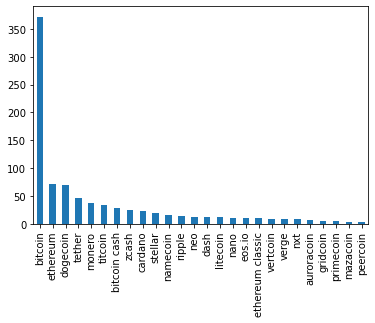

In [27]:
#############################################
## Check document count for each crypto currency

frequency = expanded_corpus['coin'].value_counts(sort=True)

frequency.head(50).plot.bar()

In [15]:
# Check contents of expanded corpus
expanded_corpus.head(2)

,coin,ticker,document_url,document
0,bitcoin,btc,https://en.wikipedia.org//wiki/Bitcoin,\n\n\n\nbitcoin () is a cryptocurrency invente...
1,litecoin,ltc,https://en.wikipedia.org//wiki/Litecoin,litecoin (ltc or ) is a peertopeer cryptocurre...


In [25]:
# Check state of teh cleansed data.
expanded_corpus.document[0]

"\n\n\n\nbitcoin () is a cryptocurrency invented in 2008 by an unknown person or group of people using the name satoshi nakamoto. the currency began use in 2009 when its implementation was released as opensource software.ch. 1 bitcoin is a decentralized digital currency, without a central bank or single administrator, that can be sent from user to user on the peertopeer bitcoin network without the need for intermediaries. transactions are verified by network nodes through cryptography and recorded in a public distributed ledger called a blockchain.\n\nbitcoins are created as a reward for a process known as mining. they can be exchanged for other currencies, products, and services, but the realworld value of the coins is extremely volatile. research produced by the university of cambridge estimated that in 2017, there were 2.9 to 5.8 million unique users using a cryptocurrency wallet, most of them using bitcoin. users choose to participate in the digital currency for a number of reasons

In [36]:
# Visually check a selection of urls ingested into the corpus:

docurl = expanded_corpus['document_url'].value_counts(sort=True)

frequency.head(15)

https://www.washingtonpost.com/news/the-switch/wp/2018/06/14/bitcoins-astronomical-rise-last-year-was-buoyed-by-market-manipulation-researchers-say/    2
https://motherboard.vice.com/en_us/article/jpgv8k/monero-cryptocurrency-dark-net-drug-dealers-hope-more-anonymous-than-bitcoin-alphabay                 2
//ssrn.com/abstract=3195066                                                                                                                             2
//arxiv.org/archive/cs.CR                                                                                                                               2
http://www.businessinsider.com/keith-rabois-stellar-foundation-2014-7                                                                                   2
https://tether.to/                                                                                                                                      2
https://www.cnbc.com/2017/08/03/bitcoin-cash-price-potential-limited-but-a-c

<AxesSubplot:>

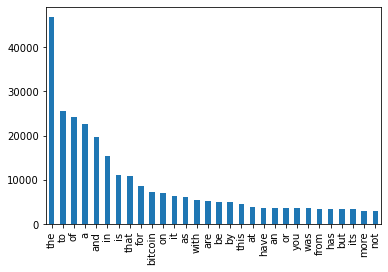

In [40]:
# Check word frequency distribution
expanded_corpus.document.str.split(expand=True).stack().value_counts().head(30).plot.bar()

<AxesSubplot:>

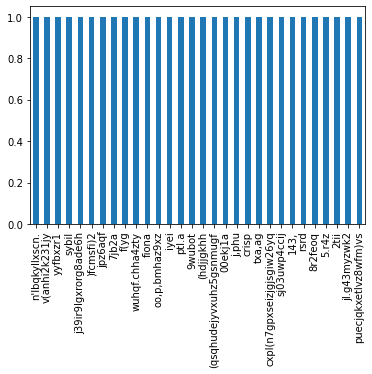

In [41]:
# Check word frequency distribution
expanded_corpus.document.str.split(expand=True).stack().value_counts().tail(30).plot.bar()